In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [123]:
test = pd.read_csv('E:\\python\\2.PROJECTS\\loan\\data\\test.csv')
train = pd.read_csv('E:\\python\\2.PROJECTS\\loan\\data\\train.csv')

In [124]:
train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [125]:
train.shape

(58645, 13)

In [126]:
train_df = train.copy()
test_df = test.copy()

In [127]:
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

In [128]:
cat_cols = train_df.select_dtypes(include=['object']).columns

In [129]:
cat_cols

Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'cb_person_default_on_file'],
      dtype='object')

In [130]:
num_cols = train_df.select_dtypes(exclude=['object']).columns
num_cols

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'loan_status'],
      dtype='object')

In [131]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for cols in cat_cols:
  train_df[cols] = le.fit_transform(train_df[cols])
  test_df[cols] = le.transform(test_df[cols])


In [132]:
import pickle
with open('label_encoder','wb') as f:
    pickle.dump(le,f)

In [133]:
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0
1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0
2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0
3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0
4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0


# A base line model executions

In [134]:
from catboost import CatBoostClassifier,Pool,cv

In [135]:
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']

In [136]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [137]:
features = cat_cols.to_list()

train_pool = Pool(X_train,y_train,cat_features=features)
test_pool = Pool(X_test,y_test,cat_features=features)


# optuna
def objective(trial):
    params={
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 0,
        "loss_function":trial.suggest_categorical("loss_function", ["Logloss"]), # Logistic loss for binary classification
        "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide"]), # for large dataset
        "eval_metric": trial.suggest_categorical("eval_metric", ["AUC"])    # efficient for imbalanced dataset
    }

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)

    # Predict and evaluate
    preds = model.predict(test_pool)
    accuracy = accuracy_score(test_pool.get_label(), preds)
    return accuracy  # Higher is better


#     catboost_params = {
#     'depth': 7,
#     'learning_rate': 0.19893301995319765,
#     'bagging_temperature': 0.7979373495258176,
#     'l2_leaf_reg': 5,
#     'loss_function': 'Logloss',
#     'iterations': 400,
#     'grow_policy': 'Lossguide',
#     'eval_metric': 'AUC',
# }


import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [138]:
catboost_params ={
    'iterations': 533,
    'depth': 8,
    'learning_rate': 0.04122611042070721,
    'l2_leaf_reg': 3.562136493550602,
    'border_count': 178,
    'random_strength': 0.006204084998060666,
    'bagging_temperature': 0.7414746060270054,
    'loss_function': "Logloss",
    'grow_policy': "Lossguide",
    'eval_metric': "AUC"
    }

In [139]:
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool)

0:	total: 780ms	remaining: 6m 55s
1:	total: 1.1s	remaining: 4m 51s
2:	total: 1.37s	remaining: 4m 2s
3:	total: 1.66s	remaining: 3m 38s
4:	total: 2.03s	remaining: 3m 34s
5:	total: 2.3s	remaining: 3m 22s
6:	total: 2.56s	remaining: 3m 12s
7:	total: 2.77s	remaining: 3m 1s
8:	total: 3.01s	remaining: 2m 55s
9:	total: 3.2s	remaining: 2m 47s
10:	total: 3.4s	remaining: 2m 41s
11:	total: 3.59s	remaining: 2m 35s
12:	total: 3.78s	remaining: 2m 31s
13:	total: 4s	remaining: 2m 28s
14:	total: 4.22s	remaining: 2m 25s
15:	total: 4.42s	remaining: 2m 22s
16:	total: 4.61s	remaining: 2m 20s
17:	total: 4.82s	remaining: 2m 17s
18:	total: 5.02s	remaining: 2m 15s
19:	total: 5.26s	remaining: 2m 15s
20:	total: 5.45s	remaining: 2m 12s
21:	total: 5.65s	remaining: 2m 11s
22:	total: 5.88s	remaining: 2m 10s
23:	total: 6.09s	remaining: 2m 9s
24:	total: 6.29s	remaining: 2m 7s
25:	total: 6.49s	remaining: 2m 6s
26:	total: 6.68s	remaining: 2m 5s
27:	total: 6.94s	remaining: 2m 5s
28:	total: 7.23s	remaining: 2m 5s
29:	total:

In [140]:
y_test_pred = model.predict(X_test)

In [141]:
y_test_df_pred = model.predict(test_df)

In [142]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def score(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, rf.predict_proba(test_df), multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("report:",report)
    # print("ROC-AUC:", roc_auc)

In [143]:
score(y_test ,y_test_pred)

Accuracy: 0.9531076818143064
Precision: 0.933107806073512
Recall: 0.8672902331334944
F1-score: 0.8962451953320365
report:               precision    recall  f1-score   support

           0       0.96      0.99      0.97     10059
           1       0.91      0.75      0.82      1670

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.90     11729
weighted avg       0.95      0.95      0.95     11729



Confusion Matrix:


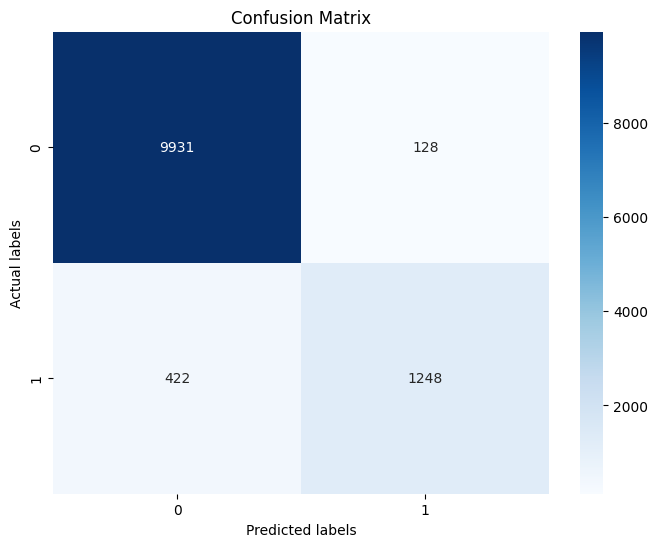

In [144]:
cm = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix")
plt.show()

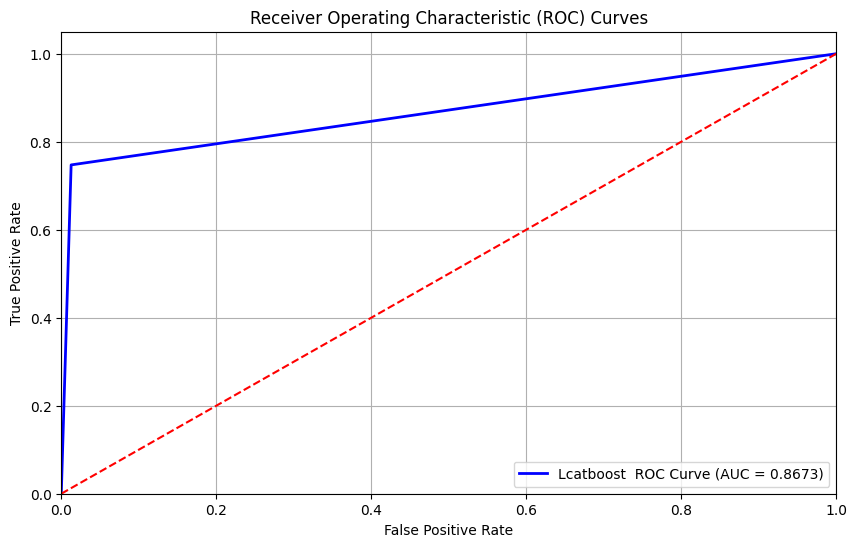

In [145]:
from sklearn.metrics import roc_curve, auc
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_pred)
cat_auc = auc(fpr_lgbm, tpr_lgbm)

# fpr_catboost, tpr_catboost, _ = roc_curve(catboost_true_labels, catboost_predictions)
# roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'Lcatboost  ROC Curve (AUC = {cat_auc:.4f})')
# plt.plot(fpr_catboost, tpr_catboost, color='green', lw=2, label=f'CatBoost ROC Curve (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# __observation__
-  __there is a slight trade-off between precision and recall. The model's recall (0.86) is lower than its precision (0.93), indicating that it might be missing some true positives.__

# __solution__
- __drop features with high corelation or collinearity__
- __class imabalance by using smote__

<Axes: >

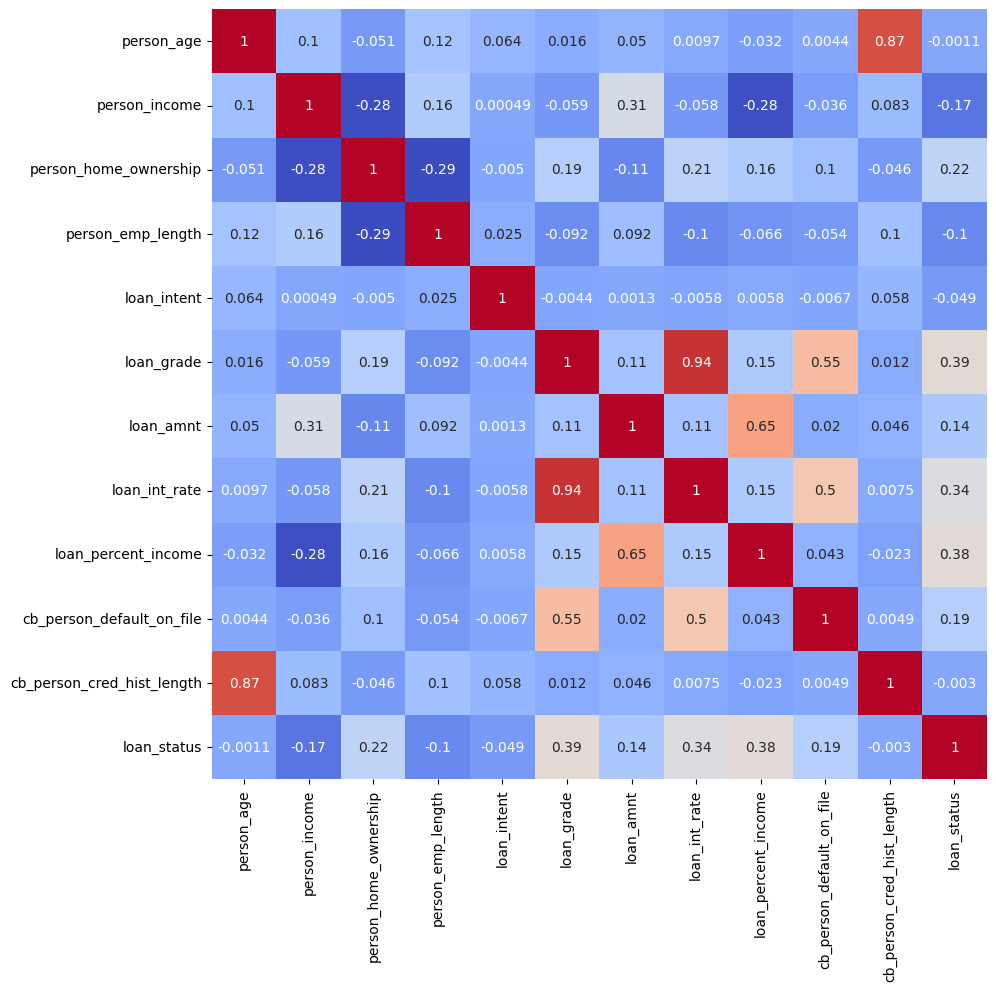

In [33]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.corr(),annot=True,cbar=False,cmap='coolwarm')

__traget leakage observed in__
- __cred_hist_length and age both show collinearity__
- __loan intrest rate and loan grade__

__But almight catboost is robust if we drop columns we might lose accuracy__ 

In [46]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_mutlicollinearity(X):
    '''
    This assumes that predictors are not correlated with each other and calculates VIF values of predictors
    '''
  
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    possible_multicollinearity = sum([1 for v in vif if v > 15])
    definite_multicollinearity = sum([1 for v in vif if v > 30])
    
    print('{} cases of possible multicollinearity.'.format(possible_multicollinearity))
    print('{} cases of definite multicollinearity.'.format(definite_multicollinearity))
    
    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied.')
        else:
            print('Assumption possibly satisfied.')
    else:
        print('Assumption not satisfied.')
    
    return pd.DataFrame({'vif': vif}, index=X.columns).round(2)

In [45]:
check_mutlicollinearity(train_df)

5 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption possibly satisfied.


,vif
person_age,56.87
person_income,7.40
person_home_ownership,2.90
person_emp_length,2.67
loan_intent,3.13
loan_grade,12.23
loan_amnt,12.30
loan_int_rate,59.83
loan_percent_income,13.55
cb_person_default_on_file,1.69


In [53]:
check_mutlicollinearity(train_df.drop(['person_age','loan_percent_income'],axis=1))

1 cases of possible multicollinearity.
0 cases of definite multicollinearity.
Assumption possibly satisfied.


,vif
person_income,4.60
person_home_ownership,2.81
person_emp_length,2.60
loan_intent,3.06
loan_grade,7.52
loan_amnt,4.38
loan_int_rate,23.22
cb_person_default_on_file,1.69
cb_person_cred_hist_length,3.08
loan_status,1.49


__OBSERVATIONS__
- __VIF score of loan_int_rate decreased when we dropped loan_percent_income__
- __Also in age__

# __catbooost with smote__

In [148]:
train_df= train.copy()
test_df= test.copy()

In [149]:
train_df.drop('id',axis=1,inplace=True)
test_df.drop('id',axis=1,inplace=True)

In [150]:
# train_df.drop(['person_age','loan_percent_income'],axis=1,inplace=True)
# test_df.drop(['person_age','loan_percent_income'],axis=1,inplace=True)

In [151]:
train_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [152]:
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']

In [153]:
X

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3
...,...,...,...,...,...,...,...,...,...,...,...
58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10
58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3


In [154]:
from sklearn.preprocessing import LabelEncoder
cat_cols = X.select_dtypes(include='object')
le = LabelEncoder()
cat_cols = X.select_dtypes(include='object')

for x in cat_cols:
        X[x] = le.fit_transform(X[x])

In [155]:
from imblearn.over_sampling import SMOTE

# Create a SMOTE object
smote = SMOTE(random_state=42)

# Fit the SMOTE object to the data and transform it
X, y = smote.fit_resample(X, y)

In [156]:
print(X.shape)
print(y.shape)

(100590, 11)
(100590,)


In [157]:
from sklearn.model_selection import StratifiedKFold
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [158]:
print(train_df.shape)
print(test_df.shape)

(58645, 12)
(39098, 11)


In [159]:
print( X_train.shape, X_test.shape)

(80472, 11) (20118, 11)


In [160]:
print(y_train.shape, y_test.shape,)

(80472,) (20118,)


In [161]:
features = cat_cols.columns.to_list()
features

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

In [162]:
features = cat_cols.columns.to_list()

train_pool = Pool(X_train,y_train,cat_features=features)
test_pool = Pool(X_test,y_test,cat_features=features)


def objective(trial):
    params={
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 0,
        "loss_function":trial.suggest_categorical("loss_function", ["Logloss"]), # Logistic loss for binary classification
        "grow_policy": trial.suggest_categorical("grow_policy", ["Lossguide"]), # for large dataset
        "eval_metric": trial.suggest_categorical("eval_metric", ["AUC"])    # efficient for imbalanced dataset
    }

    model = CatBoostClassifier(**params, random_seed=42)
    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50, verbose=False)

    # Predict and evaluate
    preds = model.predict(test_pool)
    accuracy = accuracy_score(test_pool.get_label(), preds)
    return accuracy  # Higher is better


#     catboost_params = {
#     'depth': 7,
#     'learning_rate': 0.19893301995319765,
#     'bagging_temperature': 0.7979373495258176,
#     'l2_leaf_reg': 5,
#     'loss_function': 'Logloss',
#     'iterations': 400,
#     'grow_policy': 'Lossguide',
#     'eval_metric': 'AUC',
# }


import optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

In [163]:
# print("Best trial:")
# trial = study.best_trial
# print(f"  Value: {trial.value}")
# print("  Params: ")

# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

In [164]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# class_weights_dict = dict(enumerate(class_weights))


In [165]:
catboost_params ={
    'iterations': 533,
    'depth': 8,
    'learning_rate': 0.04122611042070721,
    'l2_leaf_reg': 3.562136493550602,
    'border_count': 178,
    'random_strength': 0.006204084998060666,
    'bagging_temperature': 0.7414746060270054,
    'loss_function': "Logloss",
    'grow_policy': "Lossguide",
    'eval_metric': "AUC",
    }

In [166]:
model = CatBoostClassifier(**catboost_params)
model.fit(train_pool)

0:	total: 504ms	remaining: 4m 28s
1:	total: 754ms	remaining: 3m 20s
2:	total: 1.11s	remaining: 3m 15s
3:	total: 1.49s	remaining: 3m 16s
4:	total: 1.9s	remaining: 3m 20s
5:	total: 2.52s	remaining: 3m 41s
6:	total: 4.24s	remaining: 5m 18s
7:	total: 4.82s	remaining: 5m 16s
8:	total: 5.05s	remaining: 4m 54s
9:	total: 5.31s	remaining: 4m 37s
10:	total: 5.99s	remaining: 4m 44s
11:	total: 6.35s	remaining: 4m 35s
12:	total: 6.56s	remaining: 4m 22s
13:	total: 6.92s	remaining: 4m 16s
14:	total: 7.23s	remaining: 4m 9s
15:	total: 7.52s	remaining: 4m 3s
16:	total: 7.88s	remaining: 3m 59s
17:	total: 8.23s	remaining: 3m 55s
18:	total: 8.56s	remaining: 3m 51s
19:	total: 8.91s	remaining: 3m 48s
20:	total: 9.22s	remaining: 3m 44s
21:	total: 9.52s	remaining: 3m 41s
22:	total: 9.8s	remaining: 3m 37s
23:	total: 10.1s	remaining: 3m 33s
24:	total: 10.4s	remaining: 3m 31s
25:	total: 10.7s	remaining: 3m 28s
26:	total: 11s	remaining: 3m 26s
27:	total: 11.4s	remaining: 3m 24s
28:	total: 11.6s	remaining: 3m 21s
2

In [167]:
# import pickle
# with open("CB_classifier.pkl", "wb") as f:
#     pickle.dump(model, f)

In [168]:
y_test_pred = model.predict(X_test)

In [169]:
y_test_df_pred = model.predict(test_df)

In [170]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def score(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    report = classification_report(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, rf.predict_proba(test_df), multi_class='ovr')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("report:", report)
    # print("ROC-AUC:", roc_auc)

In [171]:
score(y_test ,y_test_pred)

Accuracy: 0.9629684859329953
Precision: 0.9635393417017359
Recall: 0.9629684859329953
F1-score: 0.9629570812031354
report:               precision    recall  f1-score   support

           0       0.95      0.98      0.96     10059
           1       0.98      0.95      0.96     10059

    accuracy                           0.96     20118
   macro avg       0.96      0.96      0.96     20118
weighted avg       0.96      0.96      0.96     20118



In [172]:
roc_auc = roc_auc_score(y_test, y_test_pred, multi_class='ovr')
roc_auc

0.9629684859329952

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

Confusion Matrix:
[[9863  196]
 [ 549 9510]]


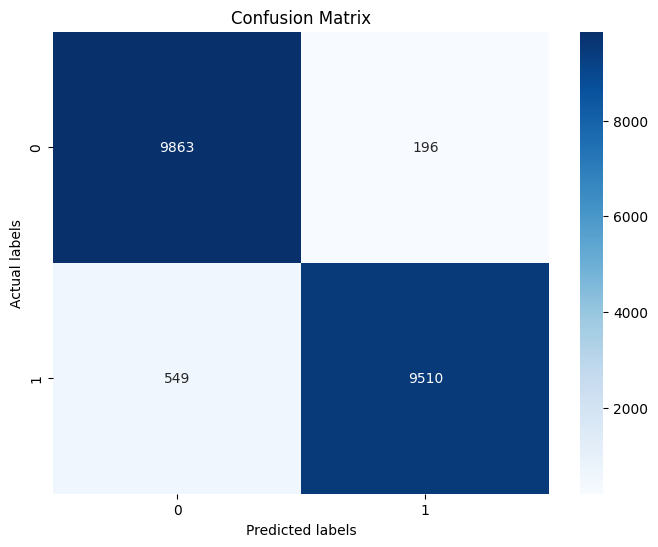

In [174]:
cm = confusion_matrix(y_test, y_test_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.title("Confusion Matrix")
plt.show()

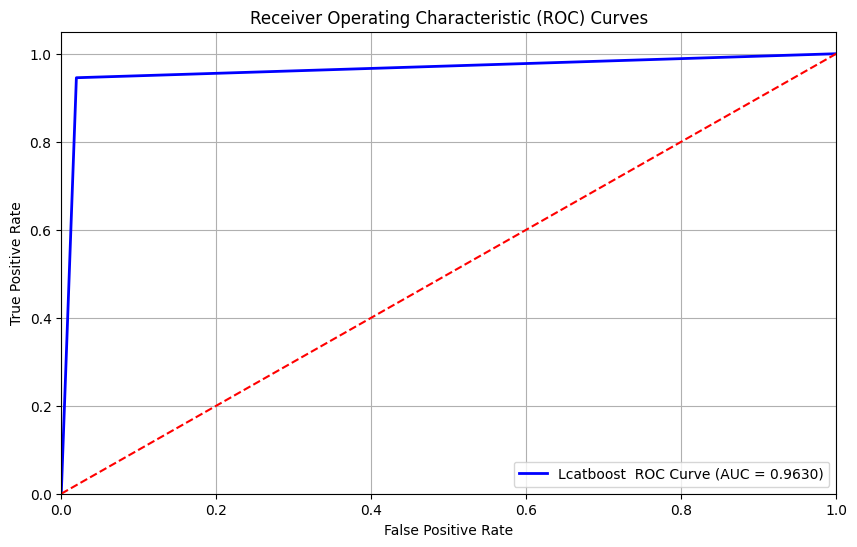

In [175]:
from sklearn.metrics import roc_curve, auc
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_test_pred)
cat_auc = auc(fpr_lgbm, tpr_lgbm)

# fpr_catboost, tpr_catboost, _ = roc_curve(catboost_true_labels, catboost_predictions)
# roc_auc_catboost = auc(fpr_catboost, tpr_catboost)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'Lcatboost  ROC Curve (AUC = {cat_auc:.4f})')
# plt.plot(fpr_catboost, tpr_catboost, color='green', lw=2, label=f'CatBoost ROC Curve (AUC = {roc_auc_catboost:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# __Result__
- __After applying SMOTE, the model's performance has improved significantly:__
- __Accuracy__: 0.9630 
- __Precision__: 0.9635 
- __Recall__: 0.9630 
- __F1-score__: 0.9630 
- __The ROC-AUC score has also improved:__
- __ROC-AUC__: 0.9630 
- __These results indicate that applying SMOTE has helped to:__
- __Improve accuracy__: The model is now correctly classifying a larger proportion of instances.
- __Improve precision__: The model is now better at avoiding false positives.
- __Improve recall__: The model is now better at detecting true positives.
- __Improve F1-score__: The model now balances precision and recall better.
- __The ROC-AUC score improvement indicates that the model is now better at distinguishing between positive and negative classes.__

## Overall, applying SMOTE has significantly improved the model's performance, and it is now performing extremely well.

In [176]:
scores = cv(params={
        'loss_function': 'Logloss',  # Specify the loss function
        'iterations': 100,
        'depth': 6,
        'learning_rate': 0.1,
        'eval_metric': 'Accuracy',
        'random_state': 42,
        'verbose': 100
    },
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    verbose=100
)

Training on fold [0/5]
0:	learn: 0.8274978	test: 0.8259195	best: 0.8259195 (0)	total: 105ms	remaining: 10.4s
99:	learn: 0.9455853	test: 0.9457629	best: 0.9459493 (98)	total: 15.2s	remaining: 0us

bestTest = 0.9459493042
bestIteration = 98

Training on fold [1/5]
0:	learn: 0.8339495	test: 0.8369579	best: 0.8369579 (0)	total: 110ms	remaining: 10.9s
99:	learn: 0.9472801	test: 0.9465639	best: 0.9465639 (99)	total: 13s	remaining: 0us

bestTest = 0.9465639369
bestIteration = 99

Training on fold [2/5]
0:	learn: 0.8400696	test: 0.8407481	best: 0.8407481 (0)	total: 113ms	remaining: 11.2s
99:	learn: 0.9470937	test: 0.9455698	best: 0.9455698 (99)	total: 12.2s	remaining: 0us

bestTest = 0.9455697776
bestIteration = 99

Training on fold [3/5]
0:	learn: 0.8324428	test: 0.8295638	best: 0.8295638 (0)	total: 109ms	remaining: 10.8s
99:	learn: 0.9445152	test: 0.9419660	best: 0.9419660 (99)	total: 12.1s	remaining: 0us

bestTest = 0.94196595
bestIteration = 99

Training on fold [4/5]
0:	learn: 0.8366367	t

In [177]:
scores.mean()

iterations             49.500000
test-Accuracy-mean      0.912001
test-Accuracy-std       0.003454
train-Accuracy-mean     0.912744
train-Accuracy-std      0.002701
test-Logloss-mean       0.246541
test-Logloss-std        0.005748
train-Logloss-mean      0.246801
train-Logloss-std       0.004820
dtype: float64

# __observation__
- __Accuracy is high__: The model achieves an average accuracy of 0.9120 on the test set and 0.9127 on the training set.\
- __Log loss is low__: The model achieves an average log loss of 0.2465 on the test set and 0.2468 on the training set.\
- __Model is stable__: The standard deviations of accuracy and log loss are low, indicating that the model's performance is stable across different folds.